In [16]:
import tensorflow as tf
import keras_tuner as kt 
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path 
from time import strftime 
import time
import tensorflowjs as tfjs
import numpy as np
import pandas as pd

## Load data

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full,y_train_full), (X_test, y_test) = fashion_mnist

In [3]:
class_names = ["Tshirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle"]

In [4]:
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [5]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255. 
X_train[0].shape

(28, 28)

#### Store img test

In [6]:
path = '../mnist-fashion-classification/public/images/'
for num,class_name in enumerate(class_names):
    index = [i for i,value in enumerate(y_test) if value==num]
    for i,lab in enumerate(index[:50]):
        os.makedirs( path + class_name, exist_ok=True)
        img_array = (X_test[lab] * 255).astype(np.uint8)
        Image.fromarray(img_array).save( path + class_name + '/' + str(i) + '.jpg')

## Models

In [7]:
tf.random.set_seed(2025)

#### Simple model

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(28, 28,1)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dense(200, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#### Model with Batch normalization

In [9]:
model_batch = tf.keras.Sequential()
model_batch.add(tf.keras.Input(shape=(28, 28, 1)))
model_batch.add(tf.keras.layers.Flatten())

# Dense layer 1
model_batch.add(tf.keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False))
model_batch.add(tf.keras.layers.BatchNormalization())
model_batch.add(tf.keras.layers.Activation('relu'))

# Dense layer 2
model_batch.add(tf.keras.layers.Dense(200, kernel_initializer='he_normal', use_bias=False))
model_batch.add(tf.keras.layers.BatchNormalization())
model_batch.add(tf.keras.layers.Activation('relu'))

# Dense layer 3
model_batch.add(tf.keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False))
model_batch.add(tf.keras.layers.BatchNormalization())
model_batch.add(tf.keras.layers.Activation('relu'))

# Output layer
model_batch.add(tf.keras.layers.Dense(10, activation='softmax'))

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model_batch.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#### Model with batch and dropout

In [10]:
model_b_r = tf.keras.Sequential()
model_b_r.add(tf.keras.layers.InputLayer(input_shape=(28, 28,1)))
model_b_r.add(tf.keras.layers.Flatten())  # <-- Add this line!


# Dense layer 1
model_b_r.add(tf.keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False))
model_b_r.add(tf.keras.layers.BatchNormalization())
model_b_r.add(tf.keras.layers.Activation('relu'))
model_b_r.add(tf.keras.layers.Dropout(0.2))

# Dense layer 2
model_b_r.add(tf.keras.layers.Dense(200, kernel_initializer='he_normal', use_bias=False))
model_b_r.add(tf.keras.layers.BatchNormalization())
model_b_r.add(tf.keras.layers.Activation('relu'))
model_b_r.add(tf.keras.layers.Dropout(0.2))

# Dense layer 3
model_b_r.add(tf.keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False))
model_b_r.add(tf.keras.layers.BatchNormalization())
model_b_r.add(tf.keras.layers.Activation('relu'))
model_b_r.add(tf.keras.layers.Dropout(0.2))

# Output layer (no regularization here usually)
model_b_r.add(tf.keras.layers.Dense(10, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model_b_r.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#### Model with batch, droutout and schedule

In [11]:
model_b_r_s = tf.keras.Sequential()
model_b_r_s.add(tf.keras.layers.InputLayer(input_shape=(28, 28,1)))
model_b_r_s.add(tf.keras.layers.Flatten())  # <-- Add this line!


# Dense layer 1
model_b_r_s.add(tf.keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False))
model_b_r_s.add(tf.keras.layers.BatchNormalization())
model_b_r_s.add(tf.keras.layers.Activation('relu'))
model_b_r_s.add(tf.keras.layers.Dropout(0.2))

# Dense layer 2
model_b_r_s.add(tf.keras.layers.Dense(200, kernel_initializer='he_normal', use_bias=False))
model_b_r_s.add(tf.keras.layers.BatchNormalization())
model_b_r_s.add(tf.keras.layers.Activation('relu'))
model_b_r_s.add(tf.keras.layers.Dropout(0.2))

# Dense layer 3
model_b_r_s.add(tf.keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False))
model_b_r_s.add(tf.keras.layers.BatchNormalization())
model_b_r_s.add(tf.keras.layers.Activation('relu'))
model_b_r_s.add(tf.keras.layers.Dropout(0.2))

# Output layer (no regularization here usually)
model_b_r_s.add(tf.keras.layers.Dense(10, activation='softmax'))

# Optimizer
initial_lr = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_b_r_s.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Train models

In [12]:
def get_run_logdir(root_logdir="my_logs"):
	return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S") 

run_logdir = get_run_logdir()  # e.g., my_logs/run_2022_08_01_17_25_59 

In [13]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir) 

In [14]:
models = [model, model_batch, model_b_r, model_b_r_s]

In [15]:
histories = []

for i,m in enumerate(models):
    start_time = time.time()
    history = m.fit(X_train, y_train,
                    epochs=200,
                    batch_size=64,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb],
                    verbose=False)
    end_time = time.time()
    elapsed_time = end_time - start_time

    histories.append(history)

    tfjs.converters.save_keras_model(m, "../models/model_v"+str(i))
    print('model:')
    print(f"Training time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    print('--------------------')

2025-06-18 09:49:23.556875: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.
/home/angel/Documents/E-commerce-Product-Images-Classification/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model:
Training time: 584.95 seconds (9.75 minutes)
--------------------


2025-06-18 09:59:08.305031: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


model:
Training time: 754.89 seconds (12.58 minutes)
--------------------


2025-06-18 10:11:43.141973: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


model:
Training time: 723.41 seconds (12.06 minutes)
--------------------


2025-06-18 10:23:46.707378: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


model:
Training time: 700.82 seconds (11.68 minutes)
--------------------


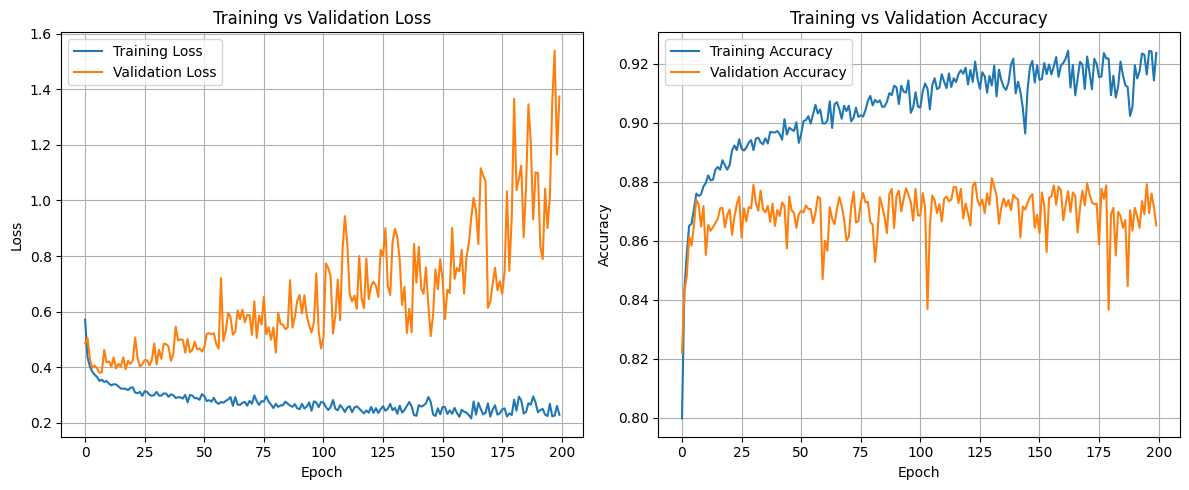

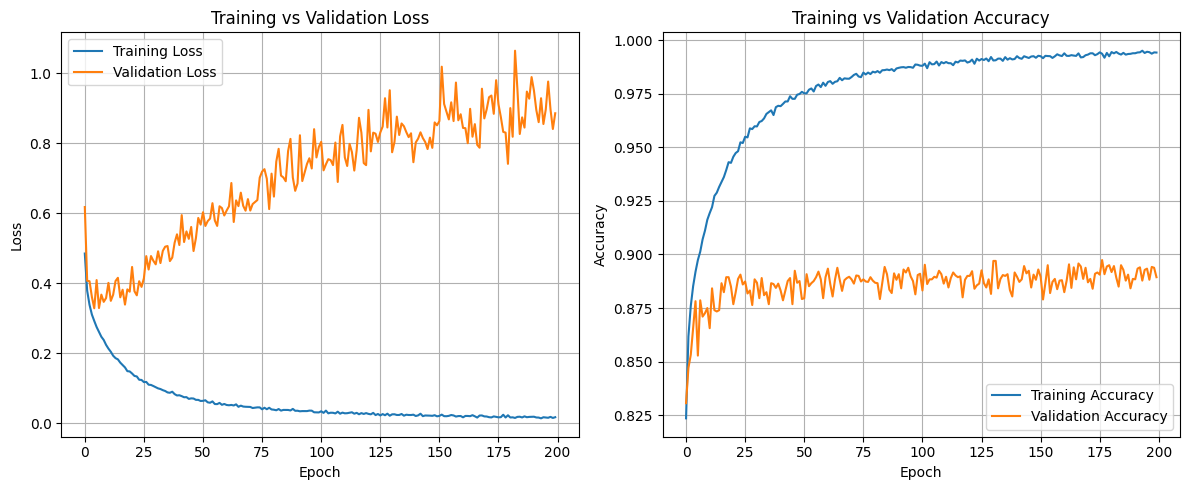

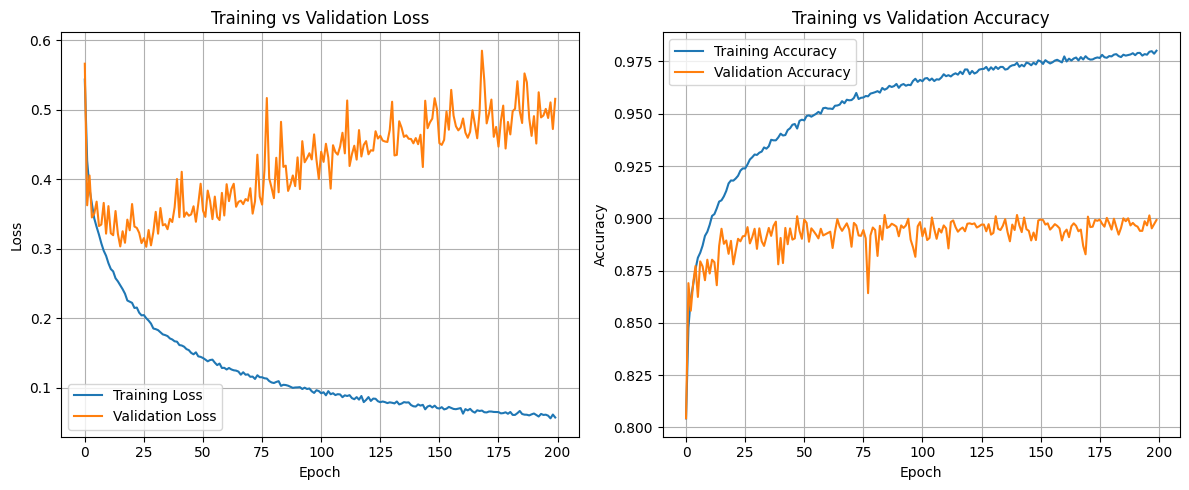

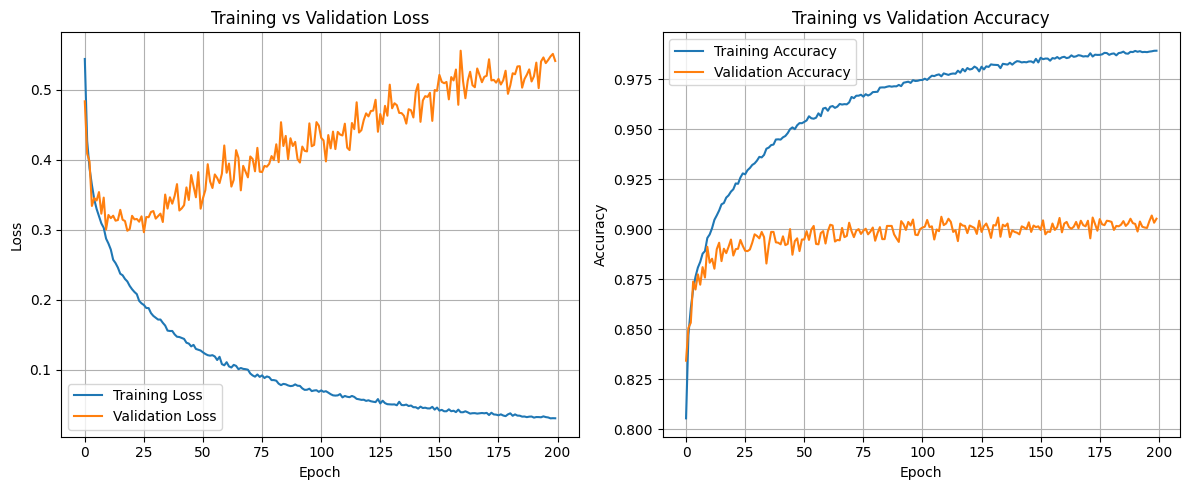

In [17]:
for history in histories:
 # Convert history to a DataFrame
    df = pd.DataFrame(history.history)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(df['loss'], label='Training Loss')
    plt.plot(df['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(df['accuracy'], label='Training Accuracy')
    plt.plot(df['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
